In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model, to_categorical

import more_itertools as mit
from tqdm import tqdm
import joblib
import pydot

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

MAX_LEN = 80
TRAIN_BATCH_SIZE = 64
# VAL_BATCH_SIZE = 32
EPOCHS = 50
MODEL_PATH = "model_LSTM_Trivia.bin"
files = {
        "train": "./data/trivia10k13train.bio", 
        "test": "./data/trivia10k13test.bio"
        }
EMBEDDING_DIM = 256

In [3]:
def prepare_vocab(files):
    train_data = pd.read_csv(files['train'], sep="\t", names=['TAG', 'WORD'], skip_blank_lines=True, dtype="string", skipfooter=1)
    test_data = pd.read_csv(files['test'], sep="\t", names=['TAG', 'WORD'], skip_blank_lines=True, dtype="string", skipfooter=1)
    
    train_vocab = set(train_data['WORD'])
    test_vocab = set(test_data['WORD'])
    
    vocab = list(train_vocab.union(test_vocab))
    return vocab

In [4]:
def read_process_and_prepare_data(files):
    
    vocab = prepare_vocab(files)
    
    word2id_dict = dict((word, idx) for idx, word in enumerate(vocab))
    id2word_dict = {idx: word for word, idx in word2id_dict.items()}
    
    df = pd.read_csv(files['train'], sep="\t", names=['TAG', 'WORD'], skip_blank_lines=False, dtype="string", skipfooter=1)
    df.drop(set(df[df['WORD'].isnull()].index.tolist()) - set(df[df['TAG'].isnull()].index.tolist()), inplace = True)
    
    df.fillna("split_at", inplace=True)
    
    filt = df['TAG']!="split_at"
    tags_enc = LabelEncoder()
    tags_enc.fit_transform(df.loc[filt, 'TAG'])
    tags2id_dict = dict(zip(tags_enc.classes_, tags_enc.transform(tags_enc.classes_)))
    
    df['TAG'] = df['TAG'].map(tags2id_dict)
    df['TAG'].fillna("split_at", inplace=True)
    
    df['WORD'] = df['WORD'].map(word2id_dict)
    df['WORD'].fillna("split_at", inplace=True)
        
    sentences = np.array(list(mit.split_at(df['WORD'].tolist(), pred=lambda x: x=='split_at')))
    tags = list(list(mit.split_at(df['TAG'], pred=lambda x: x=='split_at')))
    
    padded_tags = pad_sequences(tags, maxlen=MAX_LEN, padding='post', value=-1)
    padded_tags = to_categorical(padded_tags)
    
    padding_value = len(vocab) + 1
    padded_sentences = pad_sequences(sentences, maxlen=MAX_LEN, padding='post', truncating='post', value=padding_value)
    
    dataset = {
                "sentences": sentences,
                "padded_sentences": padded_sentences,
                "tags": padded_tags,
                "tags_enc": tags_enc,
                "word2id": word2id_dict,
                "id2word": id2word_dict,
                "tags2id": tags2id_dict,
                "vocab_len": len(vocab)
              }
    
    return dataset

In [5]:
def create_model(input_dim, output_dim, seq_len, num_tags):
    model = Sequential()
    
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=seq_len))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
    model.add(LSTM(units=output_dim, return_sequences=True))
#     model.add(LSTM(units=output_dim, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(Dense(output_dim//2, activation="relu"))
    model.add(Dense(output_dim//4, activation="relu"))
    model.add(Dense(num_tags, activation="softmax"))
    
    optimizer = Adam(learning_rate = 0.001)
    
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [6]:
def train_network(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(x=X_train, y=y_train, batch_size = TRAIN_BATCH_SIZE, validation_data=(X_val, y_val), epochs = EPOCHS, callbacks=early_stopping)
    return history, model

In [7]:
def prepare_test_data(file, tag_enc, tags2id_dict, word2id_dict, vocab_len):
    df = pd.read_csv(file, sep="\t", names=['TAG', 'WORD'], skip_blank_lines=False, dtype="string", skipfooter=1)
    df.fillna("split_at", inplace=True)
    
    filt = df['TAG']!="split_at"
    tag_enc.transform(df.loc[filt, 'TAG'])
#     tags2id_dict = dict(zip(tags_enc.classes_, tags_enc.transform(tags_enc.classes_)))
    
    df['TAG'] = df['TAG'].map(tags2id_dict)
    df['TAG'].fillna("split_at", inplace=True)
    
    df['WORD'] = df['WORD'].map(word2id_dict)
    df['WORD'].fillna("split_at", inplace=True)
        
    sentences = np.array(list(mit.split_at(df['WORD'].tolist(), pred=lambda x: x=='split_at')))
    tags = list(list(mit.split_at(df['TAG'], pred=lambda x: x=='split_at')))
    
    padded_tags = pad_sequences(tags, maxlen=MAX_LEN, padding='post', value=-1)
    padded_tags = to_categorical(padded_tags)
    
    padding_value = vocab_len
    padded_sentences = pad_sequences(sentences, maxlen=MAX_LEN, padding='post', truncating='post', value=padding_value)
    
    test_dataset = {
                    "sentences": sentences,
                    "padded_sentences": padded_sentences,
                    "tags": tags,
                    "padded_tags": padded_tags
                    }
    
    return test_dataset

In [8]:
if __name__ == '__main__':
    dataset = read_process_and_prepare_data(files)
    
    X_train, X_val, y_train, y_val = train_test_split(dataset['padded_sentences'], np.array([np.array(x) for x in dataset['tags']]), random_state=42, test_size=0.1)
    
    model = create_model(input_dim=dataset['vocab_len'] + 2, output_dim=EMBEDDING_DIM, seq_len=MAX_LEN, num_tags=len(dataset['tags_enc'].classes_))
    
    history, model = train_network(model, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))
    

c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 256)           3109632   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 512)           1050624   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 512)           1574912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 256)           787456    
_________________________________________________________________
dropout (Dropout)            (None, 80, 256)           0         
_________________________________________________________________
dense (Dense)                (None, 80, 128)           32896     
_________________________________________________________________
dense_1 (Dense)              (None, 80, 64)            8

## Model performance on test data

In [9]:
test_dataset = prepare_test_data(file=files['test'], tag_enc=dataset['tags_enc'], tags2id_dict=dataset['tags2id'], word2id_dict=dataset['word2id'], vocab_len=dataset['vocab_len'])
test_predictions = model.predict(test_dataset['padded_sentences'])
predicted_tags = []
for i in range(len(test_dataset['tags'])):
    predicted_tags.append( np.argmax(test_predictions[i], axis=1)[:len(test_dataset['sentences'][i])] )

print(classification_report(np.concatenate(test_dataset['tags']), np.concatenate(predicted_tags)))

c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1274
         1.0       0.53      0.59      0.56        66
         2.0       0.41      0.45      0.43       283
         3.0       0.76      0.87      0.81       425
         4.0       0.72      0.80      0.76       789
         5.0       0.34      0.13      0.19       195
         6.0       0.44      0.38      0.41       190
         7.0       0.50      0.38      0.43      1577
         8.0       0.00      0.00      0.00        47
         9.0       0.19      0.05      0.07       171
        10.0       0.00      0.00      0.00         8
        11.0       0.89      0.96      0.93       661
        12.0       0.92      0.90      0.91      1553
        13.0       0.44      0.76      0.56       147
        14.0       0.44      0.28      0.34       227
        15.0       0.78      0.88      0.83       411
        16.0       0.79      0.69      0.73       544
        17.0       0.00    

c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import matplotlib.pyplot as plt

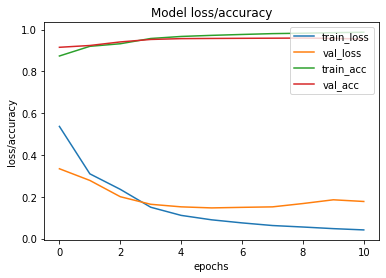

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Model loss/accuracy")
plt.xlabel("epochs")
plt.ylabel("loss/accuracy")
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc = 'upper right')
plt.show()

## Model performance on train data

In [21]:
df = pd.read_csv(files['train'], sep="\t", names=['TAG', 'WORD'], skip_blank_lines=False, dtype="string", skipfooter=1)
df.drop(set(df[df['WORD'].isnull()].index.tolist()) - set(df[df['TAG'].isnull()].index.tolist()), inplace = True)

df.fillna("split_at", inplace=True)

filt = df['TAG']!="split_at"
dataset['tags_enc'].transform(df.loc[filt, 'TAG'])
#     tags2id_dict = dict(zip(tags_enc.classes_, tags_enc.transform(tags_enc.classes_)))

df['TAG'] = df['TAG'].map(dataset['tags2id'])
df['TAG'].fillna("split_at", inplace=True)

df['WORD'] = df['WORD'].map(dataset['word2id'])
df['WORD'].fillna("split_at", inplace=True)

sentences = np.array(list(mit.split_at(df['WORD'].tolist(), pred=lambda x: x=='split_at')))
tags = list(list(mit.split_at(df['TAG'], pred=lambda x: x=='split_at')))

padded_tags = pad_sequences(tags, maxlen=MAX_LEN, padding='post', value=-1)
padded_tags = to_categorical(padded_tags)

padding_value = dataset['vocab_len']
padded_sentences = pad_sequences(sentences, maxlen=MAX_LEN, padding='post', truncating='post', value=padding_value)

train_dataset = {
                "sentences": sentences,
                "padded_sentences": padded_sentences,
                "tags": tags,
                "padded_tags": padded_tags
                }

c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [22]:
train_predictions = model.predict(train_dataset['padded_sentences'])
predicted_tags = []
for i in range(len(train_dataset['tags'])):
    predicted_tags.append( np.argmax(train_predictions[i], axis=1)[:len(train_dataset['sentences'][i])] )

print(classification_report(np.concatenate(train_dataset['tags']), np.concatenate(predicted_tags)))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5010
         1.0       0.67      0.61      0.64       309
         2.0       0.67      0.72      0.70      1024
         3.0       0.86      0.92      0.89      1787
         4.0       0.80      0.84      0.82      3384
         5.0       0.46      0.18      0.26       810
         6.0       0.54      0.46      0.49       779
         7.0       0.71      0.59      0.64      6468
         8.0       0.00      0.00      0.00       126
         9.0       0.44      0.12      0.18       580
        10.0       0.00      0.00      0.00        50
        11.0       0.93      0.98      0.96      2702
        12.0       0.96      0.97      0.96      6121
        13.0       0.56      0.85      0.68       719
        14.0       0.72      0.54      0.62       760
        15.0       0.87      0.94      0.90      1653
        16.0       0.79      0.71      0.75      2283
        17.0       0.00    

c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python3.7.8\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model.save(MODEL_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_LSTM_Trivia.bin\assets
